Training CIFAR10 Classifier
Follow the Sung Kim exercise by changing the `optimizers` not network!
DPN network takes 7hrs with `p3.2xlarge`

References:<br> 
https://www.youtube.com/watch?v=113b7O3mabY&list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m&index=5<br>
https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/<br>
git@github.com:kuangliu/pytorch-cifar.git

In [33]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x        

In [35]:
# Define a Loss function and optimizer
net = Net()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Rprop(net.parameters(), lr=0.001)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)# best one
# optimizer = torch.optim.ASGD(net.parameters(), lr=0.001)
# optimizer = torch.optim.Adagrad(net.parameters(), lr=0.001)

In [23]:
# Net model Sung Kim, Official docs
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./cifar-10-classifier/traing_data/', 
                                        train=True,
                                        download=True, 
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./cifar-10-classifier/testing_data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=4,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [36]:
# Train the network
import os
model_directory_path = '/home/jovyan/work/cifar-10-classifier/model/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print(f"Loaded model parameters from disk.")
else:
    for epoch in range(2):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            # Computer loss
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f"{epoch + 1}, {i+1}, {running_loss/2000}")
                running_loss = 0.0
    print(f"Finished Training")
    torch.save(net.state_dict(), model_path)
    print(f"Saved model parameters to disk")

1, 2000, 1.8543944607377052
1, 4000, 1.603652361229062
1, 6000, 1.528085955247283
1, 8000, 1.4681542510390282
1, 10000, 1.46179886084795
1, 12000, 1.4098220385462046
2, 2000, 1.35464448081702
2, 4000, 1.3510149261020123
2, 6000, 1.3524481324665247
2, 8000, 1.324898198839277
2, 10000, 1.3212777344360949
2, 12000, 1.3152193854302168
Finished Training
Saved model parameters to disk


In [16]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

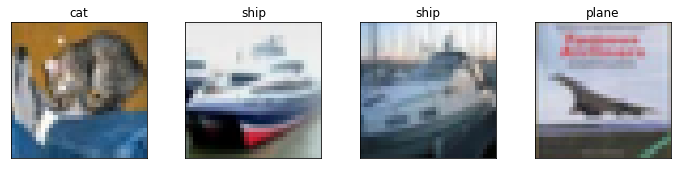

In [17]:
# Show the images
dataiter = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [37]:
# Test the network and construct the confusion matrix
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 52.95%


In [38]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 59.8
car        - 71.9
bird       - 54.0
cat        - 26.9
deer       - 32.9
dog        - 41.9
frog       - 72.7
horse      - 57.3
ship       - 63.4
truck      - 48.7


SGD<br>
Category   - Accuracy<br>
plane      - 43.1<br>
car        - 51.4<br>
bird       - 43.1<br>
cat        - 50.2<br>
deer       - 30.6<br>
dog        - 33.0<br>
frog       - 81.6<br>
horse      - 51.4<br>
ship       - 84.2<br>
truck      - 63.4<br>

Rprop<br>
Category   - Accuracy<br>
plane      - 38.0<br>
car        - 20.1<br>
bird       - 51.9<br>
cat        - 8.4<br>
deer       - 0.4<br>
dog        - 2.9<br>
frog       - 18.5<br>
horse      - 33.5<br>
ship       - 15.4<br>
truck      - 26.6<br>

RMSprop<br>
Category   - Accuracy<br>
plane      - 64.0<br>
car        - 64.0<br>
bird       - 57.8<br>
cat        - 25.3<br>
deer       - 35.9<br>
dog        - 56.1<br>
frog       - 70.2<br>
horse      - 53.6<br>
ship       - 70.8<br>
truck      - 54.7

ASGD<br>
Category   - Accuracy<br>
plane      - 46.8<br>
car        - 32.4<br>
bird       - 8.9<br>
cat        - 24.2<br>
deer       - 18.3<br>
dog        - 17.0<br>
frog       - 63.1<br>
horse      - 53.8<br>
ship       - 29.4<br>
truck      - 57.6

Adamax<br>
Category   - Accuracy<br>
plane      - 57.6<br>
car        - 78.2<br>
bird       - 35.1<br>
cat        - 36.2<br>
deer       - 38.4<br>
dog        - 37.8<br>
frog       - 68.8<br>
horse      - 71.6<br>
ship       - 58.8<br>
truck      - 58.4

Adagrad<br>
plane      - 49.5<br>
car        - 36.8<br>
bird       - 13.4<br>
cat        - 16.5<br>
deer       - 20.4<br>
dog        - 41.9<br>
frog       - 59.8<br>
horse      - 37.6<br>
ship       - 45.6<br>
truck      - 51.4

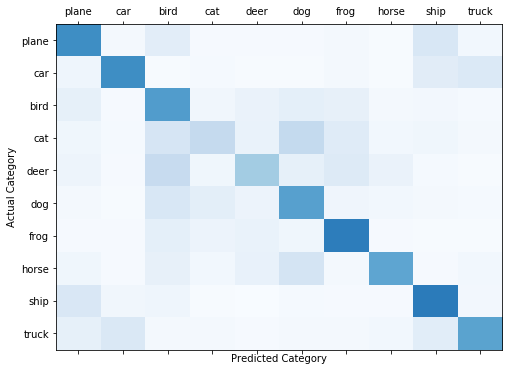

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()